# Process model fitting results
Natalia Vélez, March 2022

In this notebook, we'll check the distributions of best-fitting parameter values and prepare an n_participants x n_models matrix of model evidnces for use in Bayesian model selection.

In [1]:
%matplotlib inline

import os, re, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import teaching_models as teach
from os.path import join as opj

sys.path.append('..')
from utils import read_json, gsearch, str_extract

sns.set_style('white')
sns.set_context('talk')

Loading teaching problems
{'A': [[0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0]],
 'B': [[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'C': [[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'D': [[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]}
Participants excluded from analysis:
[3, 17]
Cleaning up human behavioral data
    subject  run  block_idx  ex_idx first_movement   start  problem  \
0         1    1          0       0         [0, 1]  [0, 0]       22   
1         1    1          0       1         [0, 1]  [0, 0]       22   
3         1    1          1   

Helper function: Replace weights

In [2]:
def expand_weights(res):
    full_weights = np.array(res['weights'])
    full_weights[np.not_equal(full_weights, 0)] = res['x']
    return full_weights

## Human model fitting

### Data wrangling

Find human model fitting results:

In [3]:
fit_files = gsearch('outputs/fit_model-*_method-optimize/*.json')
fit_files.sort()

print(f'Found {len(fit_files)} files')
print(*fit_files[:10], sep='\n')
print('...')

Found 308 files
outputs/fit_model-cost_method-optimize/sub-01_model-cost_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-02_model-cost_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-04_model-cost_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-05_model-cost_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-06_model-cost_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-07_model-cost_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-08_model-cost_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-09_model-cost_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-10_model-cost_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-11_model-cost_method-optimize_result.json
...


In [4]:
sub_list = []

for f in fit_files:
    res = read_json(f)
    sub_df = pd.DataFrame({
        'sub': str_extract('sub-[0-9]{2}', f),
        'model': res['label'],
        'weight_label': ['info', 'pref', 'cost'],
        'weight_value': expand_weights(res)
    })
    sub_df['loglik'] = -res['fun']
    sub_list.append(sub_df)

human_df = pd.concat(sub_list)
human_weights = human_df.copy().drop(columns='loglik').reset_index(drop=True) # df of best-fitting weights
optimize_lik = ( # df of likelihoods
    human_df
    .copy()
    .drop(columns=['weight_label', 'weight_value'])
    .drop_duplicates()
    .reset_index(drop=True)
)

Add model likelihoods from strong sampling:

In [5]:
strong_files = gsearch('outputs/fit_model-strong_method-grid', '*desc-params.csv')
strong_files.sort()

strong_lik = pd.concat([pd.read_csv(f) for f in strong_files])
strong_lik = (
    strong_lik
    .assign(sub = strong_lik['subject'].apply(lambda s: 'sub-%02d' % s))
    .drop(columns=['subject'])
)

human_lik = pd.concat([optimize_lik, strong_lik])

print(human_lik.shape)
human_lik.head()

(336, 3)


,sub,model,loglik
0,sub-01,cost,-248.913569
1,sub-02,cost,-260.082411
2,sub-04,cost,-252.655922
3,sub-05,cost,-263.761850
4,sub-06,cost,-267.476599


Check weights dataframe:

In [6]:
print(human_weights.shape)
human_weights.head()

(924, 4)


,sub,model,weight_label,weight_value
0,sub-01,cost,info,0
1,sub-01,cost,pref,0
2,sub-01,cost,cost,2.37434
3,sub-02,cost,info,0
4,sub-02,cost,pref,0


### Assemble matrix of model evidences

Get sample sizes

In [7]:
sample_sizes = (
    teach.human_df
    .groupby('subject')
    .agg({'example': 'count'})
    .reset_index()
    .rename(columns={'subject': 'sub'})
)
sample_sizes['sub'] = sample_sizes['sub'].apply(lambda s: 'sub-%02d' % s)
sample_sizes.head()

,sub,example
0,sub-01,108
1,sub-02,114
2,sub-04,113
3,sub-05,114
4,sub-06,115


Approximate marginal posterior using BIC:

In [8]:
human_bic = human_lik.merge(sample_sizes)
human_bic['n_param'] = human_bic.model.apply(lambda m: len(m.split('_')))
human_bic['n_param'] = np.where(human_bic.model == 'strong', 0, human_bic.n_param) # special case: strong sampling
human_bic['BIC'] = human_bic.n_param*np.log(human_bic.example)-2*human_bic.loglik
human_bic['model_evidence'] = -0.5*human_bic.BIC
human_bic.head()

,sub,model,loglik,example,n_param,BIC,model_evidence
0,sub-01,cost,-248.913569,108,1,502.509269,-251.254634
1,sub-01,literal_cost,-241.494859,108,2,492.353980,-246.176990
2,sub-01,literal,-252.244198,108,1,509.170526,-254.585263
3,sub-01,literal_pref_cost,-213.466264,108,3,440.978922,-220.489461
4,sub-01,literal_pref,-227.600676,108,2,464.565614,-232.282807


Matrix of model evidences:

In [9]:
evidence_df = (
    human_bic
    [['sub', 'model', 'model_evidence']]
    .copy()
    .pivot(index='sub', columns='model', values='model_evidence')
)
human_model_evidences = evidence_df.copy().to_numpy()
subject_labels = evidence_df.index.values
model_labels = evidence_df.columns.values

print(human_model_evidences.shape)
print(human_model_evidences)

(28, 12)
[[-251.25463438 -254.58526313 -246.17698979 -232.28280678 -220.48946075
  -258.87398338 -252.19486403 -234.79346893 -224.68125537 -232.74832359
  -223.37089438 -257.20168717]
 [-262.45051049 -256.19930781 -247.20119953 -254.49742475 -243.64567255
  -273.17850944 -264.24084969 -270.41006741 -259.67227026 -268.17469986
  -257.75366178 -271.03539907]
 [-255.01961551 -260.66385338 -239.3577453  -221.68548306 -195.28966086
  -264.1781242  -246.05330552 -226.44601372 -204.2496697  -227.4089064
  -208.41498469 -268.96600787]
 [-266.12994971 -270.73182638 -262.09797286 -262.30964114 -251.49253134
  -273.63905639 -266.35169414 -264.78531054 -255.39661372 -263.26408539
  -253.92037212 -273.21096745]
 [-269.84906554 -269.48021862 -260.62066328 -257.6258369  -244.96683159
  -276.91606684 -270.28343112 -264.54699311 -254.90038278 -262.68664756
  -254.05834315 -275.48456501]
 [-281.42772472 -281.6478023  -281.01802354 -259.16373756 -255.81998046
  -284.05326288 -283.8130673  -260.4647539  -

Save outputs to file:

In [10]:
# create output directory
out_dir = 'outputs/human_model_comparison'
os.makedirs(out_dir, exist_ok=True)

# populate with matrix of model evidences
np.savetxt(opj(out_dir, 'human_model_evidence.txt'), human_model_evidences)
np.savetxt(opj(out_dir, 'subject_labels.txt'), subject_labels, fmt='%s')
np.savetxt(opj(out_dir, 'model_labels.txt'), model_labels, fmt='%s')

# also save model evidence to file
human_bic.to_csv(opj(out_dir, 'human_model_evidence_summary.csv'))

### Check distribution of best-fitting parameter values

Keep only parameters that were fit to data

In [11]:
# arrange models roughly by decreasing complexity
weight_levels = ['info', 'pref', 'cost']
model_levels = ['pragmatic_pref_cost', 'literal_pref_cost', 'pragmatic_pref', 'literal_pref', 'pragmatic_cost', 'literal_cost', 'pragmatic', 'literal', 'pref_cost',  'pref', 'cost']
def fit_vars(model_label):
    model_parts = model_label.split('_')
    model_parts = [re.sub(r'pragmatic|literal', 'info', s) for s in model_parts]
    return model_parts

# assemble dataframe of best-fitting parameter values
filtered_weights = human_weights.copy()
is_fit_var = filtered_weights.apply(lambda row: row['weight_label'] in fit_vars(row['model']), axis=1)
filtered_weights = filtered_weights[is_fit_var].reset_index(drop=True)

# reorder categorical vars
filtered_weights['weight_label'] = filtered_weights.weight_label.astype('category').cat.reorder_categories(weight_levels)
filtered_weights['model'] = filtered_weights.model.astype('category').cat.reorder_categories(model_levels)

print(filtered_weights.shape)
filtered_weights.head()

(560, 4)


,sub,model,weight_label,weight_value
0,sub-01,cost,cost,2.37434
1,sub-02,cost,cost,2.76409
2,sub-04,cost,cost,3.36204
3,sub-05,cost,cost,2.53307
4,sub-06,cost,cost,2.29934


Plot distribution of fit parameters

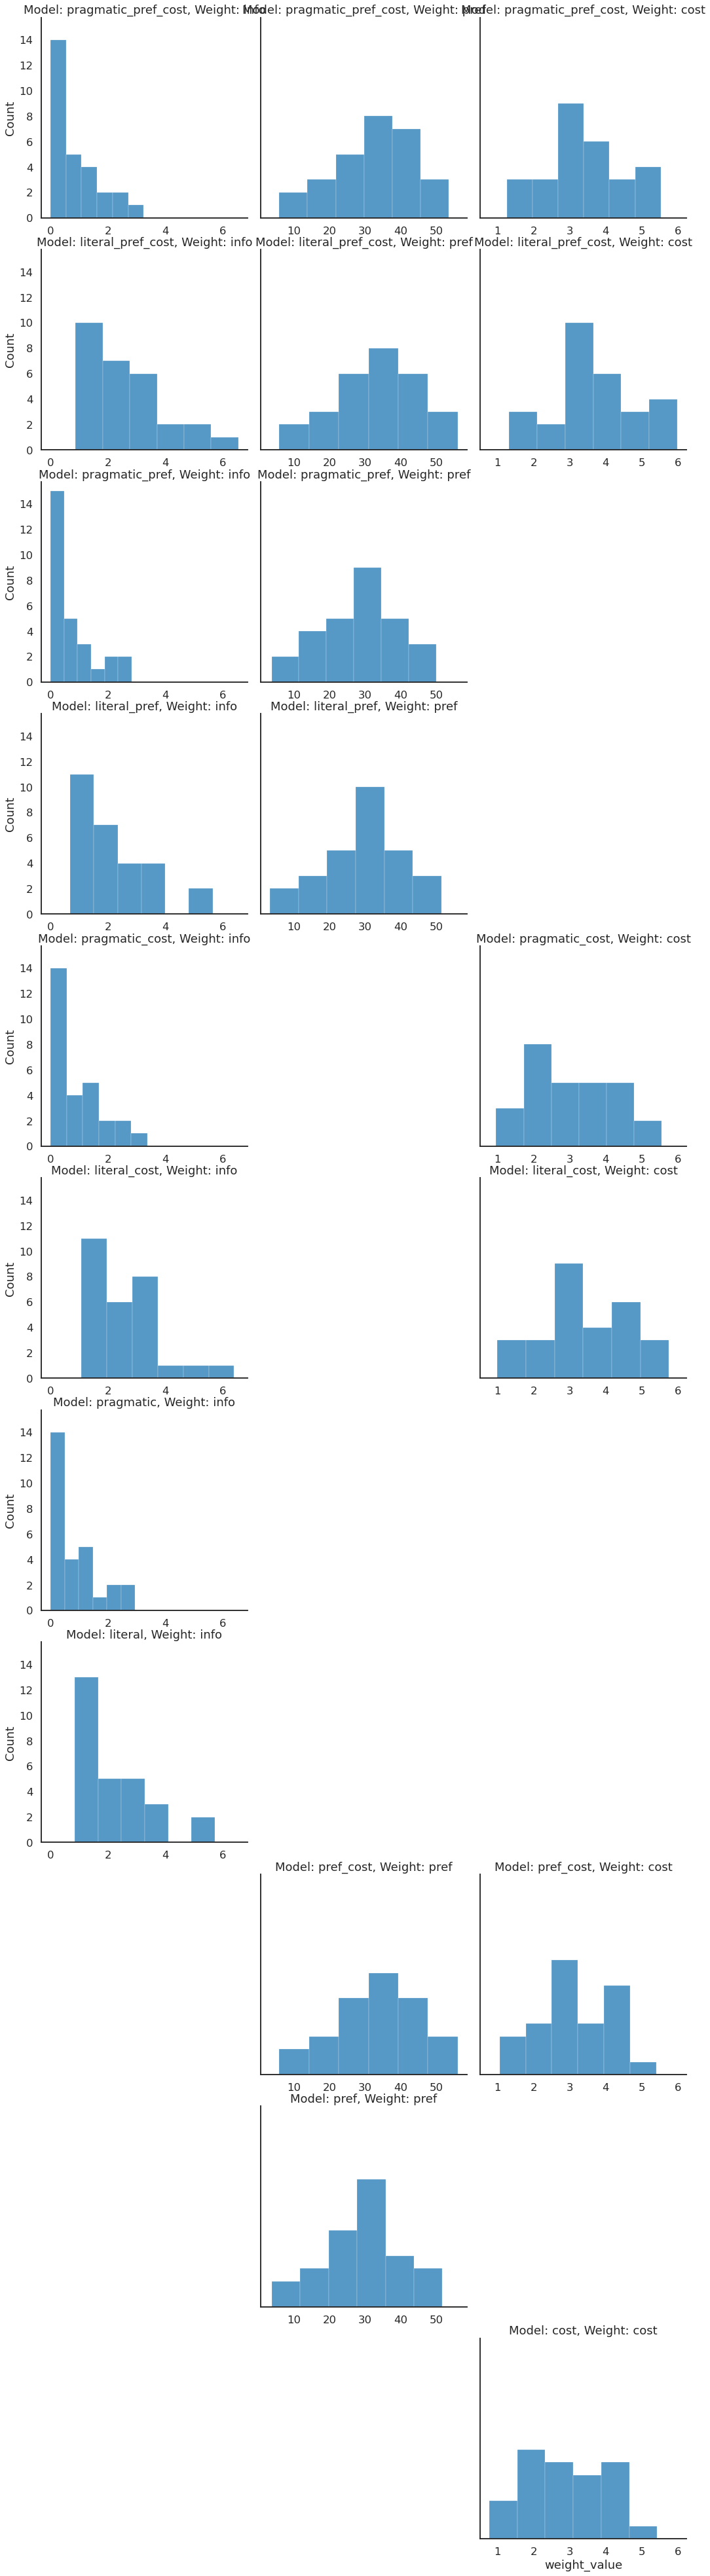

In [12]:
g = sns.displot(data=filtered_weights, row='model', col='weight_label', x='weight_value', common_bins=False, facet_kws={'sharex': 'col'})
g.set_axis_labels(xlabel='Estimated weight')
g.set_titles(template='Model: {row_name}, Weight: {col_name}')

# remove blank facets
for m_idx,m in enumerate(model_levels):
    for w_idx,w in enumerate(weight_levels):
        if w not in fit_vars(m):
            g.axes[m_idx,w_idx].axis('off')
            g.axes[m_idx,w_idx].set(title='')
        
        # show x-axis labels on every non-empty facet
        g.axes[m_idx,w_idx].tick_params(labelbottom=True)
        
plt.savefig('plots/model_MLE.png')

## Model recovery

Find model recovery files:

In [13]:
recovery_files = gsearch('outputs/model_recovery/*.json')
recovery_files.sort()

print(f'Found {len(recovery_files)} files')
print(*recovery_files[:10], sep='\n')
print('...')

Found 308 files
outputs/model_recovery/recovery_sub-01_model-cost.json
outputs/model_recovery/recovery_sub-01_model-literal.json
outputs/model_recovery/recovery_sub-01_model-literal_cost.json
outputs/model_recovery/recovery_sub-01_model-literal_pref.json
outputs/model_recovery/recovery_sub-01_model-literal_pref_cost.json
outputs/model_recovery/recovery_sub-01_model-pragmatic.json
outputs/model_recovery/recovery_sub-01_model-pragmatic_cost.json
outputs/model_recovery/recovery_sub-01_model-pragmatic_pref.json
outputs/model_recovery/recovery_sub-01_model-pragmatic_pref_cost.json
outputs/model_recovery/recovery_sub-01_model-pref.json
...


Compute model evidences:

In [14]:
recovery_list = []
for f in recovery_files:
    # read individual model recovery results
    f_df = (
        pd.read_json(f)
        .rename(columns={'fun': 'loglik'})
        [['subject', 'true_model', 'fit_model', 'loglik']]
    )
    
    recovery_list.append(f_df)

recovery_df = pd.concat(recovery_list)
recovery_df['loglik'] = -recovery_df['loglik']
recovery_df['n_param'] = recovery_df.fit_model.apply(lambda m: len(m.split('_')))
recovery_df['BIC'] = recovery_df.n_param*np.log(40*3)-2*recovery_df.loglik
recovery_df['model_evidence'] = -0.5*recovery_df.BIC

print(recovery_df.shape)
recovery_df.head(8)

(3388, 7)


,subject,true_model,fit_model,loglik,n_param,BIC,model_evidence
0,sub-01,cost,pragmatic_pref_cost,-277.874798,3,570.112071,-285.056035
1,sub-01,cost,pragmatic_cost,-278.578457,2,566.731898,-283.365949
2,sub-01,cost,pragmatic_pref,-285.345411,2,580.265806,-290.132903
3,sub-01,cost,pragmatic,-285.619164,1,576.025820,-288.012910
4,sub-01,cost,literal_pref_cost,-277.878198,3,570.118872,-285.059436
5,sub-01,cost,literal_cost,-278.586335,2,566.747654,-283.373827
6,sub-01,cost,literal_pref,-285.345411,2,580.265806,-290.132903
7,sub-01,cost,literal,-285.619164,1,576.025820,-288.012910


Save matrices of model evidences

In [15]:
out_dir = 'outputs/simulated_model_comparison'
os.makedirs(out_dir, exist_ok=True)

for model,group in recovery_df.groupby('true_model'):
    group_evidence = (
        group
        [['subject', 'fit_model', 'model_evidence']]
        .copy()
        .pivot(index='subject', columns='fit_model', values='model_evidence')
    )

    group_subjects = group_evidence.index.values
    group_models = group_evidence.columns.values

    # save model evidences and labels as matrices
    np.savetxt(opj(out_dir, f'model-{model}_evidence.txt'), group_evidence.to_numpy())
    np.savetxt(opj(out_dir, f'model-{model}_subject_labels.txt'), group_subjects, fmt='%s')
    np.savetxt(opj(out_dir, f'model-{model}_model_labels.txt'), group_models, fmt='%s')